# 多層パーセプトロン

多層パーセプトロン（multilayer perceptron: MLP）、あるいはFeedForward Neural Network

$$
z = h(W x + b)\\
z_l = h( \sum_{j=1} w_{jl} x_j + b_l)
$$

第$l$層の$i$番目のユニットの出力は

$$
z_i^{(l)} = h \left( \sum^{N^{(l-1)}}_{j=1} w^{(l)}_{ij} z_j^{(l-1)} + b_i^{(l)} \right)
$$

## Pytorchで試す

めちゃくちゃ単純な二値分類問題

In [26]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

In [44]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [45]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 2),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=2, bias=True)
  )
)


In [127]:
import numpy as np
from sklearn.datasets import make_blobs

class MyDataset(Dataset):
    def __init__(self, random_state=0):
        centers = [(1, 1), (-1, -1)]
        self.X, self.y = make_blobs(n_samples=10000, n_features=2, centers=centers, cluster_std=[0.5, 0.5], random_state=random_state)
        # modelの重みはtorch.float32なので合わせる
        self.X = self.X.astype(np.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx, :], self.y[idx]


dataset = MyDataset(random_state=0)
dataloader = DataLoader(dataset, batch_size=1)

for X, y in dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([1, 2])
Shape of y: torch.Size([1]) torch.int64


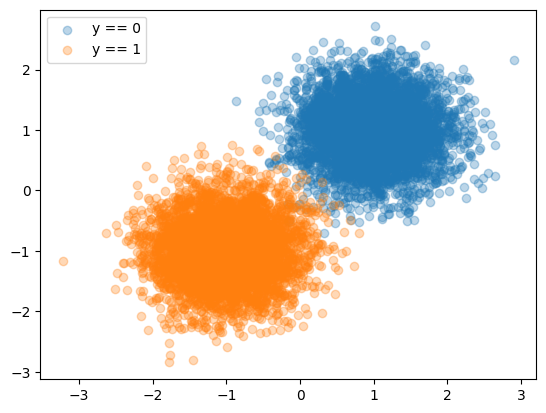

In [128]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for y in set(dataset.y):
    idx = dataset.y == y
    ax.scatter(dataset.X[idx, 0], dataset.X[idx, 1], label=f"y == {y}", alpha=0.3)
ax.legend()
fig.show()

In [129]:
learning_rate = 1e-3
epochs = 5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 1000 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [130]:
train(dataloader, model, loss_fn, optimizer)

loss: 1.285138  [    1/10000]
loss: 0.016027  [ 1001/10000]
loss: 0.093124  [ 2001/10000]
loss: 0.030537  [ 3001/10000]
loss: 0.000748  [ 4001/10000]
loss: 0.028218  [ 5001/10000]
loss: 0.044488  [ 6001/10000]
loss: 0.006413  [ 7001/10000]
loss: 0.007662  [ 8001/10000]
loss: 0.000128  [ 9001/10000]


In [131]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [132]:
dataset = MyDataset(random_state=1)
test_dataloader = DataLoader(dataset, batch_size=1)
test(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 99.6%, Avg loss: 0.017850 

